# Segmentación de Clientes para DesignReels

En el competitivo mundo del comercio electrónico, entender a fondo a nuestros clientes es fundamental para ofrecer experiencias personalizadas y maximizar la satisfacción y lealtad del cliente. Este análisis de segmentación de clientes tiene como objetivo explorar y comprender las distintas características y comportamientos de los clientes que interactúan con nuestra tienda en línea, especializada en productos creativos.

Utilizando técnicas avanzadas de análisis de datos, como clustering y segmentación, este estudio buscará identificar grupos homogéneos de clientes. Estos segmentos nos permitirán personalizar estrategias de marketing más efectivas, optimizar la selección de productos y mejorar la experiencia general de compra. Al comprender las necesidades y preferencias únicas de cada segmento, aspiramos a fortalecer la conexión emocional con la marca y aumentar la retención de clientes a largo plazo.

A lo largo de este análisis, exploraremos cómo diferentes segmentos de clientes interactúan con nuestros productos, qué atributos compartidos tienen y cómo podemos adaptar nuestras iniciativas de negocio para satisfacer mejor sus expectativas. Este enfoque estratégico no solo impulsará el crecimiento y la rentabilidad de DesignReels, sino que también nos permitirá destacar en un mercado saturado al ofrecer soluciones que verdaderamente resuenen con nuestros clientes.

Juntos, avanzaremos hacia una comprensión más profunda de nuestros clientes y hacia la creación de experiencias de compra personalizadas y significativas que fortalezcan la posición de DesignReels como líder en su categoría de productos creativos.


# Diccionario de datos 

El conjunto de datos contiene información detallada sobre las transacciones de ventas de la tienda 

Descripción de las Columnas

- invoice_no: Número de factura generado para cada transacción.
- stock_code: Código único que identifica cada producto vendido.
- description: Descripción del producto vendido.
- quantity: Cantidad de unidades vendidas de cada producto en la factura.
- invoice_date: Fecha y hora en que se emitió la factura.
- unit_price: Precio unitario del producto en la factura.
- customer_id: Identificación única del cliente que realizó la compra.
- region: Región o ubicación del cliente.
- total: Total de la venta, calculado como la cantidad vendida multiplicada por el precio unitario.

In [1265]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import plotly.graph_objects as go
from pandas.plotting import parallel_coordinates

In [1266]:
df = pd.read_csv(r'datasets\Online_Retail.csv', encoding='iso-8859-1')

In [1267]:
df.sample(10)

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
46972,540372,21980,PACK OF 12 RED RETROSPOT TISSUES,24,06/01/2020 16:41,0.29,13081.0,United Kingdom
451030,575177,23478,WOODLAND LARGE PINK FELT HEART,1,08/11/2020 18:41,2.46,NaN,United Kingdom
457022,575729,22374,AIRLINE BAG VINTAGE JET SET RED,4,10/11/2020 19:49,4.25,17932.0,United Kingdom
437317,574286,23284,DOORMAT KEEP CALM AND COME IN,4,03/11/2020 15:02,8.25,17644.0,United Kingdom
407413,571883,22944,CHRISTMAS METAL POSTCARD WITH BELLS,6,19/10/2020 13:58,0.39,14704.0,United Kingdom
529734,580750,23208,LUNCH BAG VINTAGE LEAF DESIGN,10,06/12/2020 09:56,1.65,12749.0,United Kingdom
307273,563909,23321,SMALL WHITE HEART OF WICKER,4,21/08/2020 12:36,1.65,15701.0,United Kingdom
203684,554545,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,25/05/2020 09:35,0.95,13102.0,United Kingdom
341833,566787,22385,JUMBO BAG SPACEBOY DESIGN,2,15/09/2020 10:31,4.13,NaN,United Kingdom
66628,541810,22171,3 HOOK PHOTO SHELF ANTIQUE WHITE,1,21/01/2020 15:00,16.63,NaN,United Kingdom


In [1268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Analis y limpieza de datos

In [1269]:
# Transformar los nombres de las columnas a minúsculas, eliminar los espacios 
# iniciales y finales y reemplazar los espacios con guiones bajos.

new_col_name = []

for old_name in df.columns:
    
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    new_col_name.append(name_no_spaces)

df.columns = new_col_name


In [1270]:
#cambio de tipo de la columna invoce_date a datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

#se llenan los nan de la columna customer_id con 0
df['customer_id'] = df['customer_id'].fillna(0)

#cambio del tipo de la columna customer_id a entero
df['customer_id'] = df['customer_id'].astype(int)

#se convierten las descripciones a minuscula para unificar el formato 
df['description'] = df['description'].str.lower()

In [1271]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [1272]:
#se remplaza el nombre de los paises agregaqdos como EIRE y RSA para unificar todos los nombres en ingles y mayusculas y minusculas 
df['region']= df['region'].replace('EIRE', 'Ireland')

df['region']= df['region'].replace('RSA', 'Sudafrica')

In [1273]:
#verificacion de los valores menores a cero en la columan quantity. Se toma la decision de eliminarlo al no considerar que aporten informacion relevante 
df[df['quantity'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,discount,-1,2019-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,set of 3 coloured flying ducks,-1,2019-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,plasters in tin circus parade,-12,2019-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,pack of 12 pink paisley tissues,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,pack of 12 blue paisley tissues,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,zinc t-light holder stars small,-11,2020-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,manual,-1,2020-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,victorian sewing box large,-5,2020-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,hanging heart jar t-light holder,-1,2020-12-09 11:58:00,1.25,17315,United Kingdom


In [1274]:
#verificacion de los valores menores a cero en la columan unit_price. Se toma la decision de eliminarlo al no considerar que aporten informacion relevante  
df[df['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
299983,A563186,B,adjust bad debt,1,2020-08-12 14:51:00,-11062.06,0,United Kingdom
299984,A563187,B,adjust bad debt,1,2020-08-12 14:52:00,-11062.06,0,United Kingdom


In [1275]:
#verificar que no existe ningun valor 0 en la columna quantity; sin embargo tener en cuenta que si existen aun menores a 0 
df[df['quantity'] == 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region


In [1276]:
#creacion de una nueva columana que calcula el total vendido por factura 
df['total'] = df['quantity'] * df['unit_price']

In [1277]:
#se decide eliminar del dataframe los datos que en unit_price y en customer_id sean iguales a 0, dado que consideramos no aportan ningun informacion util para futuros analisis
ceros = df.query('unit_price < 0 & customer_id < 0')

In [1278]:
#verificacion relacionado con los datos eliminados 
ceros['description'].unique()

array([], dtype=object)

In [1279]:
#verificacion relacionado con los datos eliminados 
ceros['region'].unique()

array([], dtype=object)

In [1280]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.year.unique()

array([], dtype=int32)

In [1281]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.month.unique()

array([], dtype=int32)

In [1282]:
#se filta el data frame despues de las verificaciones anteriores para conservar unicamente los datos que sean diferentes a 0 

df = df.query('unit_price > 0.0 & customer_id > 0 & quantity > 0')

In [1283]:
#Se observan los valores maximos de la columna unit price y nos damos cuenta que hay facturas que no son productos como tal, cuyos monton son muy altos dado que el valor por unidad es elevado tambien
#al parecer estas facturas corresponden a gastos de envio y/0 gastos varios que podrian afectar nuestra analisis de clientes, dado que nos interesa unicamente sus compras se eliminan del dataset
df[df['unit_price']>= 450]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
117054,546328,M,manual,1,2020-03-11 10:19:00,1687.17,14911,Ireland,1687.17
117055,546329,M,manual,1,2020-03-11 10:22:00,1687.17,14911,Ireland,1687.17
144826,548813,M,manual,1,2020-04-04 13:03:00,2382.92,12744,Singapore,2382.92
144828,548813,M,manual,1,2020-04-04 13:03:00,1252.95,12744,Singapore,1252.95
144829,548820,M,manual,1,2020-04-04 13:04:00,2053.07,12744,Singapore,2053.07
145831,548913,M,manual,1,2020-04-05 09:45:00,1136.30,12669,France,1136.30
150615,549468,M,manual,1,2020-04-08 14:27:00,1867.86,17940,United Kingdom,1867.86
173382,551697,POST,postage,1,2020-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
187584,552980,POST,postage,1,2020-05-12 14:52:00,523.00,12590,Germany,523.00
188277,553018,M,manual,1,2020-05-12 19:02:00,557.72,12757,Portugal,557.72


In [1284]:
#Se eliminando estos valores dado que no parecen ser ventas realizadas como tal por la empresa. 
df = df[~df['stock_code'].isin(['M', 'DOT', 'POST'])]

In [1285]:
df[df['unit_price']>= 450]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
222680,556444,22502,picnic basket wicker 60 pieces,60,2020-06-10 15:28:00,649.5,15098,United Kingdom,38970.0
222682,556446,22502,picnic basket wicker 60 pieces,1,2020-06-10 15:33:00,649.5,15098,United Kingdom,649.5


# Analisis exploratorio de datos

In [1286]:
# Mostrar el tiempo de compra del cliente
grouped_df = df.groupby('customer_id')


first_purchase_date = grouped_df['invoice_date'].min()
last_purchase_date = grouped_df['invoice_date'].max()


time_delta = last_purchase_date - first_purchase_date
time_in_days = time_delta.dt.days


customer_purchase_time = pd.DataFrame({'time_in_days': time_in_days}).reset_index()


customer_purchase_time['time_in_days']= customer_purchase_time['time_in_days'].replace(0, 1)
customer_purchase_time

,customer_id,time_in_days
0,12346,1
1,12347,366
2,12348,283
3,12349,1
4,12350,1
...,...,...
4330,18280,1
4331,18281,1
4332,18282,118
4333,18283,334


In [1287]:
#Creamos un Histograma para visualizar la distribucios del tiempo de vida del cliente en nuestra tienda

fig = px.histogram(customer_purchase_time, x="time_in_days", nbins=10, text_auto=True, title= 'Distribución del Tiempo de Vida del Cliente en nuestra tienda')
fig.update_layout(
    xaxis_title='Días',
    yaxis_title='Cantidad de Clientes',
    title={
        'text': 'Distribución del Tiempo de Vida del Cliente en nuestra tienda',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial Black'}
    },
    xaxis=dict(
        title_font=dict(size=18, family='Arial Black')
    ),
    yaxis=dict(
        title_font=dict(size=18, family='Arial Black')
    ),
    autosize=False,
    width=1000,  
    height=600   
)
fig.show()

**Observaciones**

En la visualizacion nos damos cuenta que hay una gran cantidad de nuestros clientes entre el rango de los 0 a los 50 dias, por lo que pueden ser clientes recientes comprando en nuestra tiendo lo cual es bueno, o tambien pueden ser clientes que ya dejaron de comprar y debemoos buscar la forma de retomarlos.

In [1288]:
def add_date_components(group):
  """
  Extracts day, month, and year from the 'invoice_date' column within a group.

  Args:
    group: A Pandas group object (subset of the DataFrame).

  Returns:
    The group with added columns 'days', 'months', and 'years'.
  """
  group['days'] = group['invoice_date'].dt.day
  group['months'] = group['invoice_date'].dt.month
  group['years'] = group['invoice_date'].dt.year
  return group

df_with_components = df.groupby('invoice_date').apply(add_date_components)

C:\Users\karin\AppData\Local\Temp\ipykernel_44380\4097401398.py:16: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [1289]:
df_with_components.head()

invoice_no stock_code  \
invoice_date                                  
2019-12-01 08:26:00 0     536365     85123A   
                    1     536365      71053   
                    2     536365     84406B   
                    3     536365     84029G   
                    4     536365     84029E   

                                               description  quantity  \
invoice_date                                                           
2019-12-01 08:26:00 0   white hanging heart t-light holder         6   
                    1                  white metal lantern         6   
                    2       cream cupid hearts coat hanger         8   
                    3  knitted union flag hot water bottle         6   
                    4       red woolly hottie white heart.         6   

                             invoice_date  unit_price  customer_id  \
invoice_date                                                         
2019-12-01 08:26:00 0 2019-12-01 08:26:00        2.55        17850   
                    1 2019-12-01 08:26:00        3.39        17850   
                    2 2019-12-01 08:26:00        2.75        17850   
                    3 2019-12-01 08:26:00        3.39        17850   
                    4 2019-12-01 08:26:00        3.39        17850   

                               region  total  days  months  years  
invoice_date                                                       
2019-12-01 08:26:00 0  United Kingdom  15.30     1      12   2019  
                    1  United Kingdom  20.34     1      12   2019  
                    2  United Kingdom  22.00     1      12   2019  
                    3  United Kingdom  20.34     1      12   2019  
                    4  United Kingdom  20.34     1      12   2019

In [1290]:
#Filtramos los datos para encontrar el top 10 de las regiones con mayores ventas
filtered= df_with_components.groupby('region')['total'].sum().reset_index().sort_values(by='total', ascending=False).head(10)
top_10_region= df_with_components['region'].tolist()
filtered_df = df_with_components[df_with_components['region'].isin(top_10_region)]
filtered_df_new= filtered_df.groupby(['region', 'days', 'months', 'years'])['total'].sum().reset_index().sort_values(by='total', ascending=False)
filtered_df_new


,region,days,months,years,total
1285,United Kingdom,9,12,2020,179562.78
1395,United Kingdom,20,9,2020,100457.88
1369,United Kingdom,18,1,2020,84035.94
1345,United Kingdom,15,9,2020,65843.34
1283,United Kingdom,9,11,2020,58843.67
...,...,...,...,...,...
532,Germany,13,12,2019,12.45
907,Netherlands,20,7,2020,11.02
1115,Sweden,11,5,2020,8.50
1162,Switzerland,21,9,2020,4.95


In [1291]:
#Creamos una visualizacion para ver la distribucion de ventas.
fig = px.scatter(filtered_df_new, x="months", y="total", color="region",
                 size='days', hover_data=['years'],
                 title='Distribucion de Ventas por dia/mes/año y region')

fig.update_layout(
    title={
        'text': 'Distribución de Ventas por día/mes/año y región', 
        'x': 0.5, 
        'xanchor': 'center', 
        'yanchor': 'top', 
        'font': {'size': 24, 'family': 'Arial', 'color': 'black'}
    },
    xaxis_title={
        'text': 'Meses', 
        'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
    },
    yaxis_title={
        'text': 'Ingresos por ventas', 
        'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
    },
    width=1200,
    height=800
)

fig.show()

**Observaciones**

La estacionalidad de ventas es bastante uniforme a lo largo del año, todas las regiones consumen nuestros productos, más o menos de la misma manera, salvo esos valores atípicos que se pueden observar en Enero y Septiembre que pueden ser un buen boost si logramos trabajaras bien. 


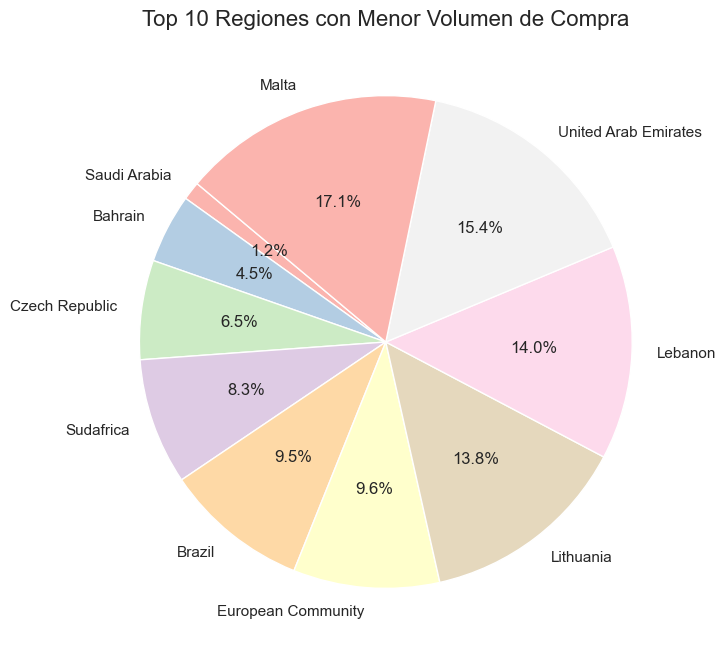

In [1292]:
#Seleccionar las 10 regiones con el menor volumen de compras
ventas_por_region = df.groupby('region')['total'].sum().sort_values()


bottom_10_regiones = ventas_por_region.head(10)


plt.figure(figsize=(15, 8))
plt.pie(bottom_10_regiones, labels=bottom_10_regiones.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Top 10 Regiones con Menor Volumen de Compra', fontsize=16)
plt.show()

**Observaciones**

Recomendamos un análisis más a fondo con lo que respecta a los países, que se encuentra al fondo del indice de compra, para tener claro la real razón del bajo índice de ventas, tal vez un centro de distribución puede levantar los números de esos sectores o tal vez sea mejor concentrarse en regiones con mayor potencial


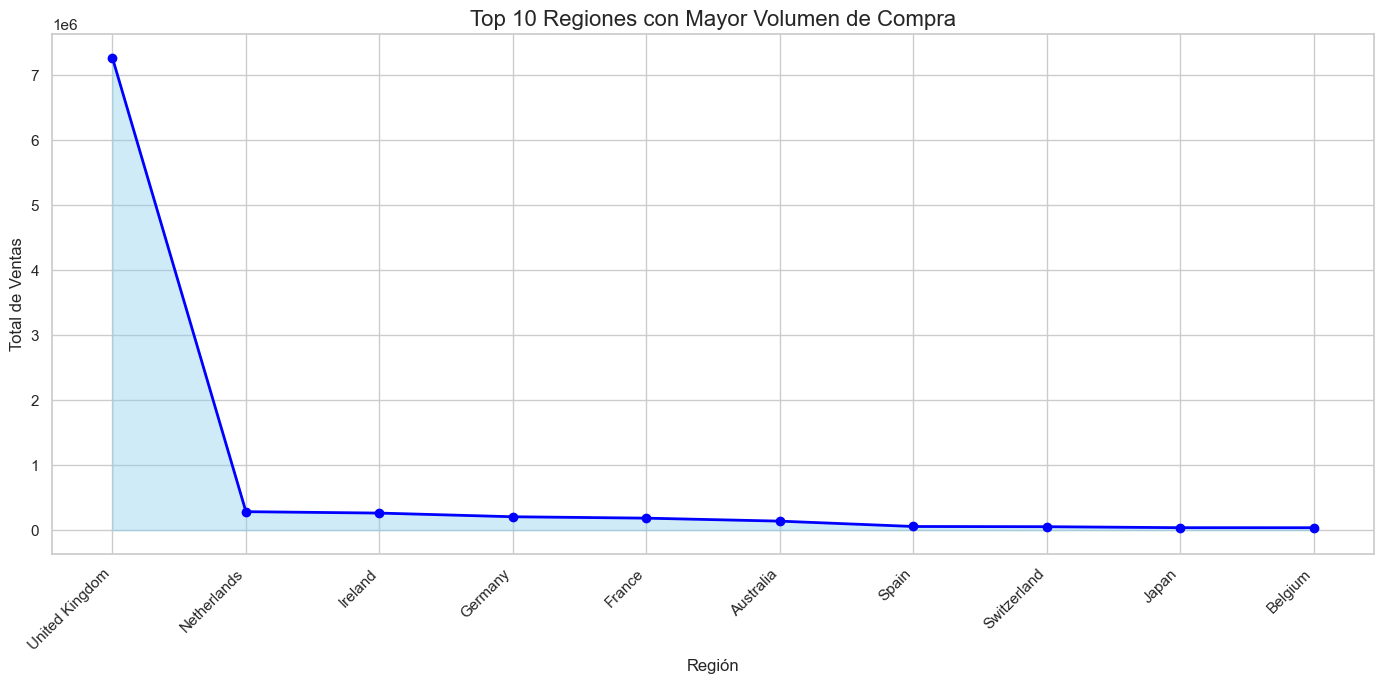

In [1293]:
#Top 10 regiones que más compran GRÁFICO DE AREA
ventas_por_region = df.groupby('region')['total'].sum().sort_values(ascending=False)

top_10_regiones = ventas_por_region.head(10)

plt.figure(figsize=(14, 7))
plt.fill_between(top_10_regiones.index, top_10_regiones.values, color='skyblue', alpha=0.4)
plt.plot(top_10_regiones.index, top_10_regiones.values, marker='o', color='blue', linewidth=2)

plt.title('Top 10 Regiones con Mayor Volumen de Compra', fontsize=16)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


**Observaciones**

El Reino Unido es la región con el mayor volumen de compras por lejos. Sin embargo, a la fecha de hoy, debemos tomar esta información con precaución, ya que los datos fueron recopilados durante el revuelo del Brexit. Tal vez sea necesario analizar más a fondo este sector. Aun así, no podemos ignorar lo mucho que se distancia de las demás regiones


In [1294]:
#Filtramos los datos para calcular los el tiempo de vida de un cliente comprando en nuestra tienda.
customer_days= df_with_components.groupby(['customer_id', 'months', 'years'])
max_days= customer_days['invoice_date'].max()
min_days= customer_days['invoice_date'].min()
total= max_days - min_days
total= total.dt.days.reset_index()
total['invoice_date']= total['invoice_date'].replace(0, 1)
total.sort_values(by='invoice_date')

,customer_id,months,years,invoice_date
0,12346,1,2020,1
7759,15835,10,2020,1
7760,15836,10,2020,1
7761,15837,10,2020,1
7762,15838,2,2020,1
...,...,...,...,...
9927,16839,7,2020,29
901,12709,3,2020,29
5824,14911,7,2020,30
4074,14156,7,2020,30


In [1295]:
#Agregamos una nueva colunma incorparando en ella valores 1 para casos de estudios a futuro de las faturaciones.
total['buy_month'] = 1
total

,customer_id,months,years,invoice_date,buy_month
0,12346,1,2020,1,1
1,12347,1,2020,1,1
2,12347,4,2020,1,1
3,12347,6,2020,1,1
4,12347,8,2020,1,1
...,...,...,...,...,...
13024,18283,10,2020,1,1
13025,18283,11,2020,19,1
13026,18283,12,2020,1,1
13027,18287,5,2020,1,1


In [1296]:
# Filtramos los datos por años para luego generar el histograma
group_1= total[total['years']== 2019]
group_2= total[total['years']== 2020]

fig = go.Figure()
fig.add_trace(go.Histogram(x=group_1['months'], name= '2019', texttemplate="%{y}", marker_line_color='black', marker_line_width=1))
fig.add_trace(go.Histogram(x=group_2['months'], name= '2020', texttemplate="%{y}", marker_line_color='black', marker_line_width=1))
fig.update_layout(
    title_text='Cantidad de compras mensuales/año', # título del gráfico
    xaxis_title_text='Meses', # título del eje x
    yaxis_title_text='Cantidad de Clientes', # título del eje y
    title={
        'font': {'size': 24, 'family': 'Arial', 'color': 'black'}
    },
    xaxis={
        'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black'}}
    },
    yaxis={
        'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black'}}
    },
    width=1200,
    height=800,
    barmode='overlay'
)

fig.update_traces(opacity=0.75)
fig.show()

**Observaciones**

Podemos observar en el gráfico que los registros del año 2019 se limitan únicamente al mes de diciembre. Este hallazgo sugiere que la disponibilidad de datos históricos para ese año es limitada, concentrándose en el último mes del año. Además, es notable que los meses de septiembre, octubre y noviembre muestran un notable aumento en el número de facturaciones mensuales, indicando que son periodos de fuerte actividad comercial y altas ventas. En contraste, el mes de diciembre muestra una disminución significativa en las ventas, lo cual señala una oportunidad para implementar estrategias que mejoren el rendimiento durante la temporada navideña y optimicen los resultados comerciales para ese periodo.

In [1297]:
# Agrupamos por Nº de factura y calcular el valor medio por transacción
average_value_per_transaction = df.groupby('invoice_no')['total'].mean().reset_index()

# Cambie el nombre de las columnas para mayor claridad
average_value_per_transaction.columns = ['invoice_no', 'average_value']

# Mostrar las primeras filas del resultado
average_value_per_transaction

,invoice_no,average_value
0,536365,19.874286
1,536366,11.100000
2,536367,23.227500
3,536368,17.512500
4,536369,17.850000
...,...,...
18411,581583,62.300000
18412,581584,70.320000
18413,581585,15.669048
18414,581586,84.800000


In [1298]:
# Agrupamos los datos por factura y totales para sacar la media de compras
invoice_totals = df.groupby('invoice_no')['total'].sum().reset_index()
average_purchase_value = invoice_totals['total'].mean()


print(invoice_totals)
print()
print('El valor promedio por compra de cada cliente es:', average_purchase_value)

      invoice_no   total
0         536365  139.12
1         536366   22.20
2         536367  278.73
3         536368   70.05
4         536369   17.85
...          ...     ...
18411     581583  124.60
18412     581584  140.64
18413     581585  329.05
18414     581586  339.20
18415     581587  249.45

[18416 rows x 2 columns]

El valor promedio por compra de cada cliente es: 476.1032609687228


In [1299]:
# Agrupar por fecha y calcular el valor medio por transacción
average_value_per_day = df_with_components.groupby(df_with_components['invoice_date'])['total'].mean().reset_index()


average_value_per_day.columns = ['date', 'average_value']


print(average_value_per_day.head())

fig = go.Figure()
fig.add_trace(go.Scatter(x=average_value_per_day['date'], y=average_value_per_day['average_value'],
                    mode='lines+markers',
                    name='lines+markers',
                    ))
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor Promedio por Compra',
    title={
        'text': 'Evolución del Valor Promedio por Compra a lo Largo del Tiempo',
        'x': 0.5,  
        'xanchor': 'center',  
        'font': {'size': 24, 'family': 'Arial', 'color': 'black', 'weight': 'bold'}  
    },
    xaxis={'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black', 'weight': 'bold'}}},  
    yaxis={'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black', 'weight': 'bold'}}}, 
    width=1200, 
    height=800  
)
fig.show()

                 date  average_value
0 2019-12-01 08:26:00      19.874286
1 2019-12-01 08:28:00      11.100000
2 2019-12-01 08:34:00      21.798750
3 2019-12-01 08:35:00      17.850000
4 2019-12-01 08:45:00      42.203158


**Observaciones**

Podemos observar en el grafico anterior 2 anomalias de compras, las cuales al verificar la primera es un cliente que ha realizado ya varias compras con nosotros y el otro es un cliente que sus primeras 2 compras fueron pequeñas pero luego el 9 de diciembre de 2020 realiza una compra grande de (80995) paper craft little birdie. el cual da un total de 168469.60

Este ultimo cliente en particular nos sugiere la posibilidad de que existan clientes que compran mayoreo de ciertos productos, para los cuales se podrian crear estrategias de marketing especiales. 

In [1300]:
# Agrupe por fecha y calcular el valor medio por transacción
average_value_per_day = df_with_components.groupby(df_with_components['invoice_date'])['total'].mean().reset_index().sort_values(by='total', ascending=False)

# Cambie el nombre de las columnas para mayor claridad
average_value_per_day.columns = ['date', 'average_value']

# Elimine las filas con índices '17149' y '1775' las cuales pertenecena los 2 datos atipicos
average_value_per_day_filtered = average_value_per_day.iloc[2:]


print(average_value_per_day_filtered.head())

fig = go.Figure()
fig.add_trace(go.Scatter(x=average_value_per_day_filtered['date'], y=average_value_per_day_filtered['average_value'],
                    mode='lines+markers',
                    name='lines+markers',
                    ))
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor Promedio por Compra',
    title='Evolución del Valor Promedio por Compra a lo Largo del Tiempo',
    width=1200,
    height=800
)

fig.show()

                     date  average_value
13796 2020-10-27 12:11:00    4992.000000
7430  2020-06-10 15:28:00    4391.711111
5156  2020-04-18 13:20:00    4307.180000
1572  2020-01-11 12:57:00    3918.750000
16989 2020-12-07 12:20:00    3861.000000



**Observaciones**

En este análisis, excluimos intencionalmente los dos valores atípicos del gráfico anterior para enfocarnos en la evolución del promedio de compra de manera más detallada. Observamos que la mayoría de los clientes tienen un promedio de compra por debajo de los 1000, pero también notamos una cantidad significativa de clientes cuyo promedio supera esta cifra. Para mejorar estos resultados, se pueden implementar estrategias como las mencionadas anteriormente para incentivar a los clientes con promedios de compra inferiores a 1000 a aumentar sus compras hacia este umbral o lo más cercano posible a él.

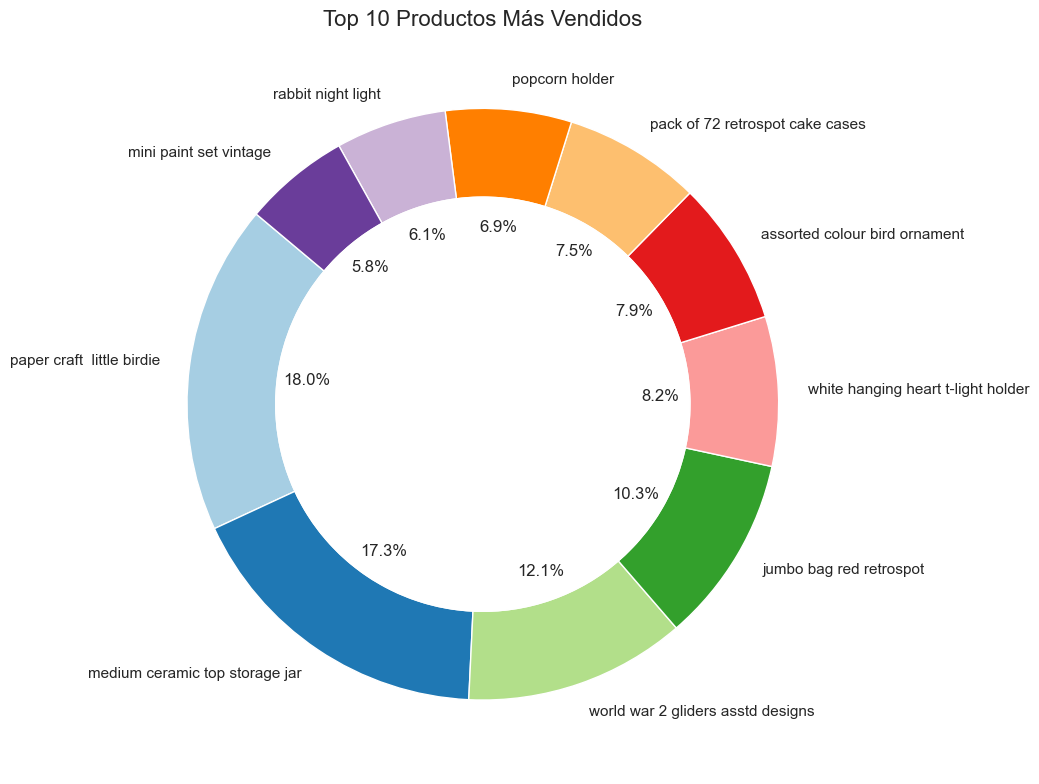

In [1301]:
#Productos más vendidos segun descripción GRAFICO DE DONA
productos_mas_vendidos = df.groupby('description')['quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 8))
plt.pie(productos_mas_vendidos, labels=productos_mas_vendidos.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.title('Top 10 Productos Más Vendidos', fontsize=16)

plt.tight_layout()
plt.show()

**Observaciones**

En esta gráfica podemos ver los productos más vendidos. Una solución para aumentar el porcentaje de venta de los productos menos populares podría ser vincularlos con aquellos que tienen mayores ventas o, en su defecto, eliminarlos para dar espacio a otros artículos que puedan generar una mayor rentabilidad.


## Conclusiones


Basado en el análisis realizado, se destacan varios puntos clave. Los meses de septiembre, octubre y noviembre muestran un notable aumento en el número de facturaciones mensuales, indicando que son los períodos de mayor actividad y ventas para la empresa. Sin embargo, el mes de diciembre presenta una disminución significativa en las ventas, señalando una oportunidad para implementar estrategias que puedan mejorar el desempeño durante este mes crucial. Además, es relevante notar que el dataset solo incluye registros del mes de diciembre de 2019, lo cual limita la visión histórica completa de los patrones de ventas anuales. Estos hallazgos subrayan la importancia de ajustar las estrategias de marketing y ventas para capitalizar los períodos de alta demanda y mejorar el rendimiento en los meses de menor actividad.


# Segmentacion de clientes 

In [1302]:

# Calcular el número de compras por cliente
numero_compras = df.groupby('customer_id')['invoice_no'].count().reset_index()
numero_compras.columns = ['customer_id', 'numero_compras']

# Calcular los ingresos totales por cliente
ingresos_totales = df.groupby('customer_id')['total'].sum().reset_index()
ingresos_totales.columns = ['customer_id', 'ingresos_totales']

# Unir los datos calculados con el DataFrame original
df = pd.merge(df, numero_compras, on='customer_id', how='left')
df = pd.merge(df, ingresos_totales, on='customer_id', how='left')

# Calcular el número de clientes únicos
numero_clientes_unicos = df['customer_id'].nunique()

# Calcular los clientes retenidos (clientes con más de una compra)
clientes_retenidos = df[df['numero_compras'] > 1]['customer_id'].nunique()

In [1303]:
# Funcion para definir al cliente como retenido o perdido 
"""
Función para categorizar clientes basado en el número de compras.

Parámetros:
- num_compras (int): Número de compras realizadas por el cliente.

Devuelve:
- str: 'retenido' si el cliente ha realizado más de una compra, 'perdido' si no.

Ejemplo de uso:
>>> categorizar_cliente(3)
'retenido'
>>> categorizar_cliente(0)
'perdido'
"""

def categorizar_cliente(num_compras):
    if num_compras > 1:
        return 'retenido'
    else:
        return 'perdido'

In [1304]:
#Aplicacion de la funcion para crear la nueva columna en el ds
df['estado_cliente'] = df['numero_compras'].apply(categorizar_cliente)

In [1305]:
#creacion de nuevas columnas para el metodo RFM 
df['AVP'] = df['ingresos_totales'] / df['numero_compras']

df['APF'] = df['numero_compras'] / numero_clientes_unicos

CR = 1 - (clientes_retenidos / numero_clientes_unicos)

In [1306]:
df['CLTV'] = (df['AVP'] * df['APF']) / CR

In [1307]:
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total,numero_compras,ingresos_totales,estado_cliente,AVP,APF,CLTV
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom,15.30,297,5391.21,retenido,18.152222,0.068512,73.852192
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,297,5391.21,retenido,18.152222,0.068512,73.852192
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom,22.00,297,5391.21,retenido,18.152222,0.068512,73.852192
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,297,5391.21,retenido,18.152222,0.068512,73.852192
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,297,5391.21,retenido,18.152222,0.068512,73.852192


In [1308]:
#se verificaron los posibles datos duplicados en todas las columanas posibles y concluimos que los duplicados existentes son coherentes. No se elimina ninguno
df['stock_code'].duplicated().sum()

392823

In [1309]:
df.describe()

,quantity,invoice_date,unit_price,customer_id,total,numero_compras,ingresos_totales,AVP,APF,CLTV
count,396485.000000,396485,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000
mean,13.008066,2020-07-10 20:02:19.138226944,2.884385,15301.436912,22.114122,662.026516,11244.428131,22.114122,0.152717,154.033262
min,1.000000,2019-12-01 08:26:00,0.001000,12346.000000,0.001000,1.000000,3.750000,2.101286,0.000231,0.051370
25%,2.000000,2020-04-07 11:16:00,1.250000,13975.000000,4.680000,90.000000,1092.390000,7.056183,0.020761,14.964247
50%,6.000000,2020-07-31 14:39:00,1.950000,15159.000000,11.800000,201.000000,2622.570000,15.080400,0.046367,35.925616
75%,12.000000,2020-10-20 14:40:00,3.750000,16801.000000,19.800000,444.000000,6068.110000,21.112403,0.102422,83.124795
max,80995.000000,2020-12-09 12:50:00,649.500000,18287.000000,168469.600000,7838.000000,279138.020000,77183.600000,1.808074,3823.808493
std,179.607863,NaN,4.354867,1709.758505,308.841950,1444.589307,30777.337890,206.091136,0.333239,421.607368


In [1310]:
#segunda verificacion del dataset antes de comenzar con los calculos 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396485 entries, 0 to 396484
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        396485 non-null  object        
 1   stock_code        396485 non-null  object        
 2   description       396485 non-null  object        
 3   quantity          396485 non-null  int64         
 4   invoice_date      396485 non-null  datetime64[ns]
 5   unit_price        396485 non-null  float64       
 6   customer_id       396485 non-null  int32         
 7   region            396485 non-null  object        
 8   total             396485 non-null  float64       
 9   numero_compras    396485 non-null  int64         
 10  ingresos_totales  396485 non-null  float64       
 11  estado_cliente    396485 non-null  object        
 12  AVP               396485 non-null  float64       
 13  APF               396485 non-null  float64       
 14  CLTV

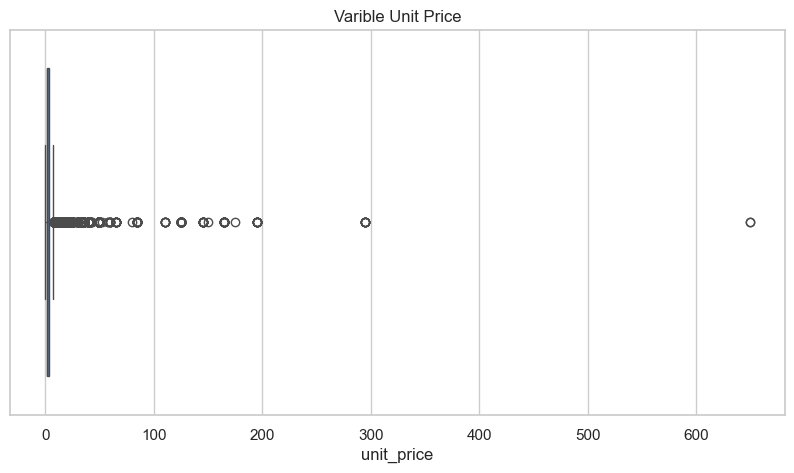

In [1311]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['unit_price'])
plt.title('Varible Unit Price')
plt.show()

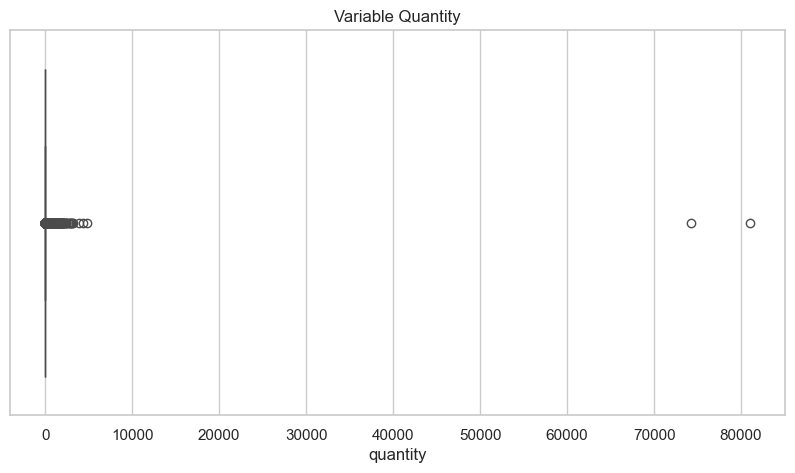

In [1312]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['quantity'])
plt.title('Variable Quantity')
plt.show()

In [1313]:
#verificacion de los outliers, estos dos productos si son ventan por lo que no se eliminan 
df[df['quantity'] > 60000]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total,numero_compras,ingresos_totales,estado_cliente,AVP,APF,CLTV
36985,541431,23166,medium ceramic top storage jar,74215,2020-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,1,77183.6,perdido,77183.6,0.000231,1057.309589
396017,581483,23843,paper craft little birdie,80995,2020-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,3,168472.5,retenido,56157.5,0.000692,2307.842466


## Aplicacion del metodo RFM 

In [1314]:

# Aplicacion del metodo RFM 

current_date = df['invoice_date'].max()

# Calcula Recencia, Frecuencia y Valor Monetario
rfm_df = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days,
    'total': ['sum', 'count'],
})

rfm_df.columns = ['Recency', 'Monetary', 'Frequency']
rfm_df.reset_index(inplace=True)

# Asigna puntuaciones RFM
rfm_df['R_rank'] = pd.qcut(rfm_df['Recency'], 5, labels=False, duplicates='drop') + 1
rfm_df['F_rank'] = pd.qcut(rfm_df['Frequency'], 5, labels=False, duplicates='drop') + 1
rfm_df['M_rank'] = pd.qcut(rfm_df['Monetary'], 5, labels=False, duplicates='drop') + 1


rfm_df['RFM_Score'] = rfm_df['R_rank'] + rfm_df['F_rank'] + rfm_df['M_rank']

display(rfm_df.head())

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score
0,12346,326,77183.60,1,5,1,5,11
1,12347,1,4310.00,182,1,5,5,11
2,12348,74,1437.24,27,4,2,4,10
3,12349,18,1457.55,72,2,4,4,10
4,12350,310,294.40,16,5,2,2,9


In [1315]:
# Aplicar IQR para Recency, Frequency, y Monetary
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

rfm_df = remove_outliers(rfm_df, 'Recency')
rfm_df = remove_outliers(rfm_df, 'Frequency')
rfm_df = remove_outliers(rfm_df, 'Monetary')

In [1316]:
#merge de los datasets para conservar el numero de cliente 
rfm_df = rfm_df.merge(df[['customer_id', 'CLTV', 'estado_cliente']].drop_duplicates(), on='customer_id', how='left')

In [1317]:
rfm_df

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente
0,12348,74,1437.24,27,4,2,4,10,19.688219,retenido
1,12349,18,1457.55,72,2,4,4,10,19.966438,retenido
2,12350,310,294.40,16,5,2,2,9,4.032877,retenido
3,12352,35,1385.74,77,3,4,4,11,18.982740,retenido
4,12353,203,89.00,4,5,1,1,7,1.219178,retenido
...,...,...,...,...,...,...,...,...,...,...
3497,18278,73,173.90,9,4,1,1,6,2.382192,retenido
3498,18280,277,180.60,10,5,1,1,7,2.473973,retenido
3499,18281,180,80.82,7,5,1,1,7,1.107123,retenido
3500,18282,7,178.05,12,1,1,1,3,2.439041,retenido


In [1318]:

"""
Función para asignar un segmento basado en el CLTV de un cliente, comparándolo con los cuantiles del DataFrame rfm_df.

Parámetros:
- cltv (float): Valor de CLTV para el cliente.

Devuelve:
- str: Segmento asignado al cliente según el valor de CLTV y los cuantiles definidos en rfm_df.

Ejemplo de uso:
>>> asignar_segmento(5000)
'Alto Valor'
>>> asignar_segmento(2000)
'Leal'
"""


def asignar_segmento(cltv):
    if cltv > rfm_df['CLTV'].quantile(0.8):  # Segmento más alto
        return 'Alto Valor'
    elif cltv > rfm_df['CLTV'].quantile(0.6):  # Segmento alto-medio
        return 'Leal'
    elif cltv > rfm_df['CLTV'].quantile(0.4):  # Segmento medio
        return 'Potencial'
    elif cltv > rfm_df['CLTV'].quantile(0.2):  # Segmento bajo-medio
        return 'Activo'
    else:  # Segmento más bajo
        return 'En riesgo/ Perdido'

# Aplicar la función al DataFrame
rfm_df['CLTV_Segment'] = rfm_df.apply(lambda x: asignar_segmento(x['CLTV']), axis=1)



In [1319]:
rfm_df.sample(10)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente,CLTV_Segment
3103,17618,5,971.58,78,1,4,4,9,13.309315,retenido,Leal
97,12514,266,1017.68,51,5,3,4,12,13.940822,retenido,Leal
1781,15373,7,2415.91,132,1,5,5,11,33.094658,retenido,Alto Valor
2850,17180,55,796.03,128,3,5,3,11,10.904521,retenido,Leal
2998,17434,1,2373.82,134,1,5,5,11,32.518082,retenido,Alto Valor
896,13870,1,2770.94,115,1,4,5,10,37.958082,retenido,Alto Valor
2915,17295,28,556.95,69,2,4,3,9,7.629452,retenido,Potencial
2164,16025,29,439.66,28,2,2,2,6,6.022740,retenido,Potencial
2191,16073,297,122.40,1,5,1,1,7,1.676712,perdido,En riesgo/ Perdido
2170,16036,86,758.92,55,4,3,3,10,10.396164,retenido,Leal


In [1320]:
#Funcion para la segmentacion de los clientes segun su RFM score
"""
Función para segmentar clientes basados en su puntuación RFM.

Parámetros:
- row (pandas.Series): Fila de un DataFrame que contiene la puntuación RFM del cliente ('RFM_Score').

Devuelve:
- str: Segmento asignado al cliente según su puntuación RFM.

Ejemplo de uso:
>>> df['Segmento'] = df.apply(segment_customer, axis=1)

Esto aplicará la función `segment_customer` a cada fila del DataFrame `df` y asignará el segmento resultante a una nueva columna 'Segmento'.
"""


def segment_customer(row):
   if row['RFM_Score'] > 12:
         return 'Alto valor'
   elif row['RFM_Score'] > 9:
    return 'Leal'
   elif row['RFM_Score'] > 6:
    return 'Potencial'
   elif row['RFM_Score'] > 3:
    return 'Activo'
   else:
     return 'Cliente Perdido' 

#Aplica la función de segmentación a cada fila del DataFrame
rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

In [1321]:
# Conteo de clientes por segmento
print(rfm_df['Segment'].value_counts())

Segment
Potencial          1665
Leal               1114
Activo              590
Alto valor           98
Cliente Perdido      35
Name: count, dtype: int64


In [1322]:
rfm_df.sample(10)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente,CLTV_Segment,Segment
107,12528,8,1645.48,86,1,4,4,9,22.540822,retenido,Alto Valor,Potencial
620,13422,63,2626.30,127,3,5,5,13,35.976712,retenido,Alto Valor,Alto valor
476,13176,45,492.84,72,3,4,3,10,6.751233,retenido,Potencial,Leal
1727,15274,3,716.57,47,1,3,3,7,9.816027,retenido,Leal,Potencial
2505,16593,50,330.03,27,3,2,2,7,4.520959,retenido,Activo,Potencial
1053,14141,2,915.13,40,1,3,3,7,12.536027,retenido,Leal,Potencial
3010,17455,203,131.70,8,5,1,1,7,1.804110,retenido,En riesgo/ Perdido,Potencial
3353,18043,24,559.51,121,2,4,3,9,7.664521,retenido,Potencial,Potencial
2153,16009,21,992.71,90,2,4,4,10,13.598767,retenido,Leal,Leal
5,12354,231,1079.40,58,5,3,4,12,14.786301,retenido,Leal,Leal


In [1323]:
rfm_df['CLTV_Segment'].value_counts()

CLTV_Segment
Alto Valor            701
En riesgo/ Perdido    701
Activo                700
Leal                  700
Potencial             700
Name: count, dtype: int64

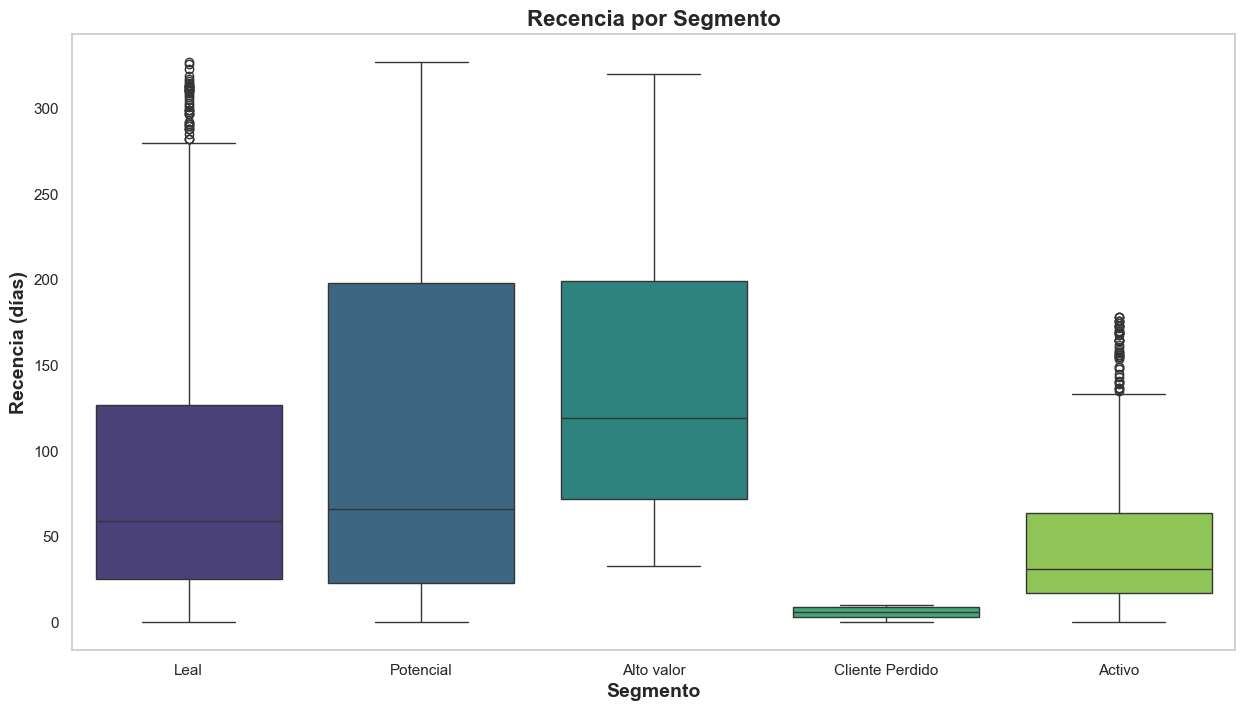

In [1324]:
# Gráfico de Caja y Bigote para Recencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Recency', palette='viridis', hue='Segment')
plt.title('Recencia por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Recencia (días)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
plt.grid(False)

#plt.savefig('recencia_por_segmento.jpeg', format='jpeg')
plt.show()

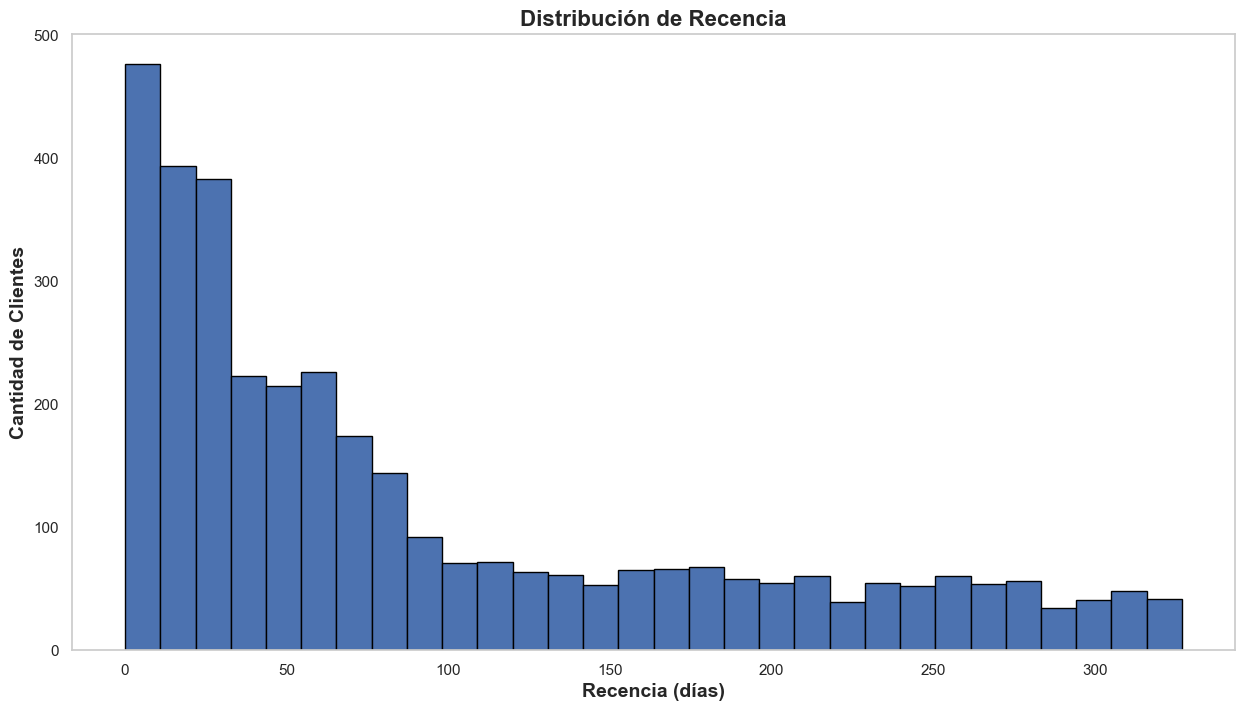

In [1325]:
# Histograma
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
rfm_df['Recency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Recencia', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
#plt.savefig('distrubicion_de_recencia.jpeg', format='jpeg')
plt.show()



**Observaciones** 

Se realizo un analisis para visualizar cuandos dias suelen esperar los clientes hasta su sigiente compra. Como se observa la mayoria de los clientes suelen esperar ente 50 y 70 dias entre sus compras.

Lo que observamos en esta gráfica es la distribución de clientes por su antigüedad. La mayor concentración de clientes se encuentra en el rango de 0 a 6 meses, lo que sugiere que la empresa tiene una alta tasa de adquisición de nuevos clientes. A medida que aumenta la antigüedad, el número de clientes disminuye, lo que indica que la empresa tiene cierta rotación de clientes.

Se muestra una distribución típica de clientes por antigüedad, con una alta concentración de nuevos clientes y una disminución gradual a medida que aumenta la antigüedad. Esto sugiere que la empresa es efectiva en la adquisición de nuevos clientes, pero necesita mejorar sus estrategias de retención para mantener a los clientes a lo largo del tiempo.


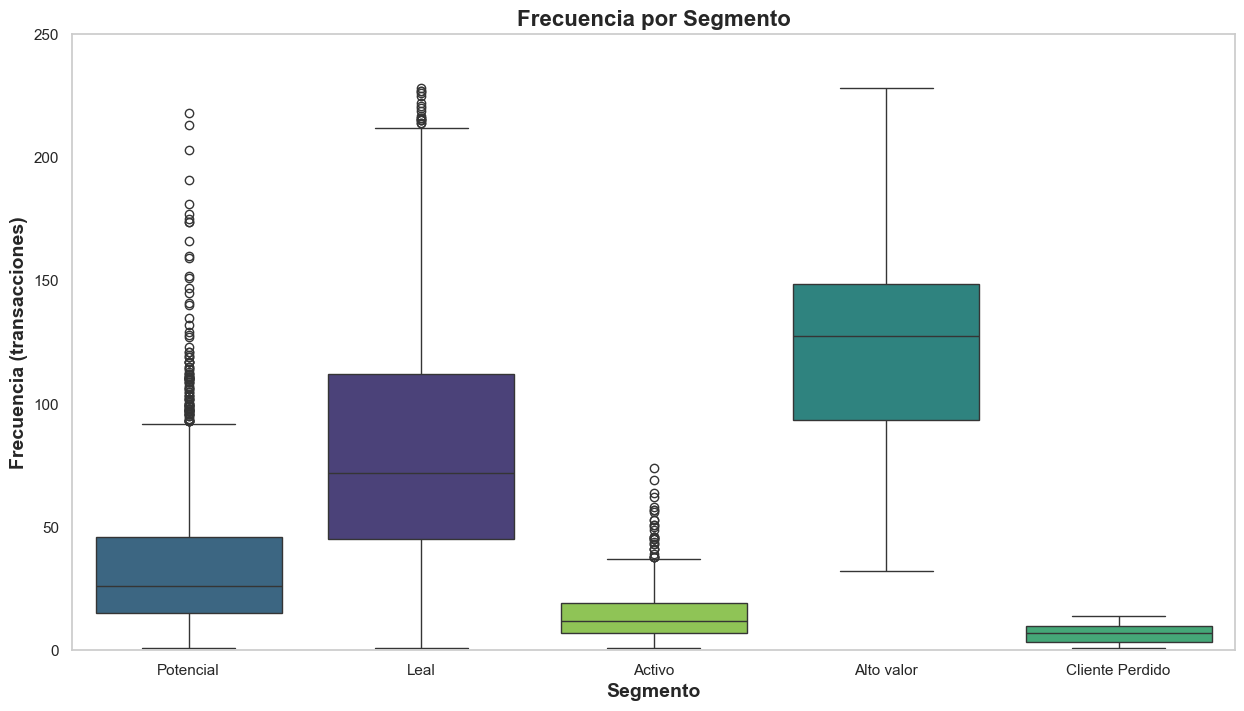

In [1326]:
# Gráfico de Caja y Bigote para Frecuencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Frequency', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment' )#showfliers=False
plt.title('Frecuencia por Segmento',  fontsize=16, fontweight='bold')
plt.xlabel('Segmento',  fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia (transacciones)',  fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
#plt.ylim(0, 410) CON OUTLIERS
plt.ylim(0, 250)
plt.grid(False)
#plt.savefig('frecuencia_por_segmento.jpeg', format='jpeg')
plt.show()



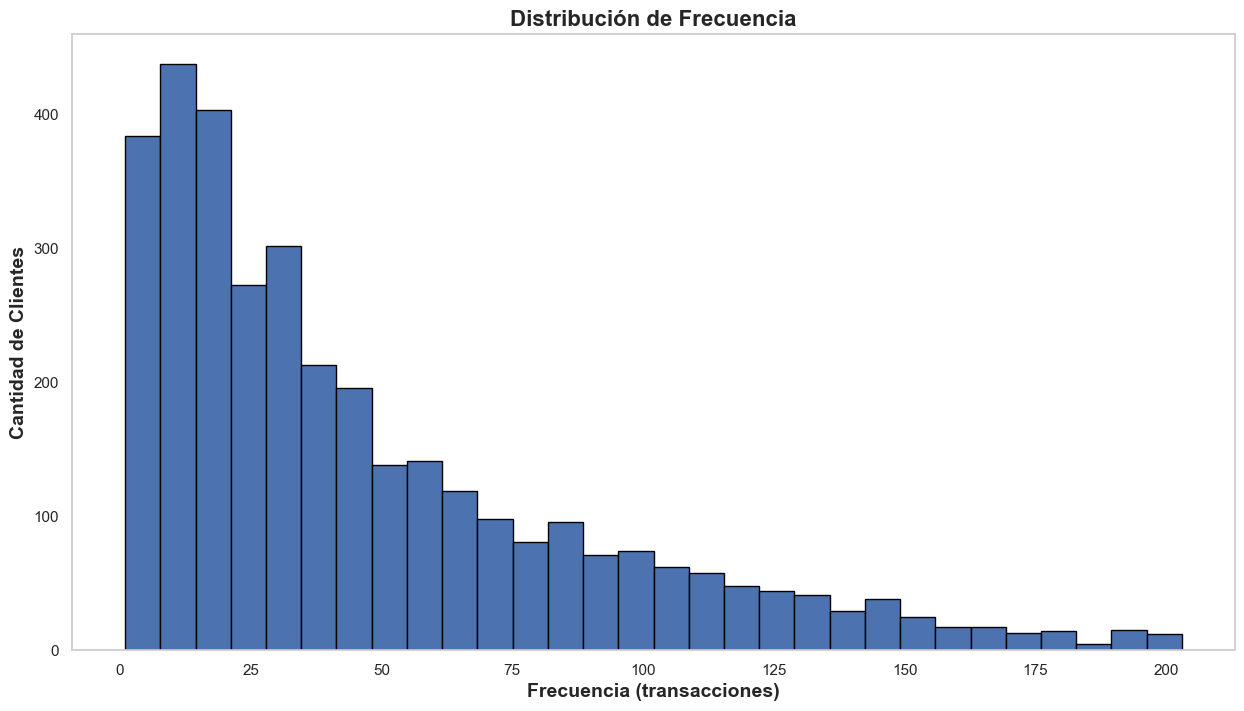

In [1327]:
#histograma
sns.set(style="whitegrid")
filtered_data_f = rfm_df[rfm_df['Frequency'] < rfm_df['Frequency'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_f['Frequency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Frecuencia', fontsize=16, fontweight='bold')
plt.xlabel('Frecuencia (transacciones)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
#plt.savefig('distribucion_de_frecuencia.jpeg', format='jpeg')
plt.show()



**Observaciones**

Podemos observar que existe mas cantidad de cuentes que realizan entre 1 y 50 compras, mientras que resulta menos comun que los clientes realicen mas de 100 compras dentro de la tienda. La alta concentración de clientes en el rango de 1 a 50 compras sugiere que la empresa tiene una base de clientes amplia y diversa, con muchos clientes que realizan compras ocasionales o de baja frecuencia.

La presencia de clientes que realizan más de 100 compras indica que la empresa tiene un segmento de clientes leales y comprometidos que generan un alto volumen de ventas. Sin embargo, el número relativamente bajo de clientes en este segmento sugiere que existe un potencial para aumentar la fidelidad y el gasto entre los clientes existentes.

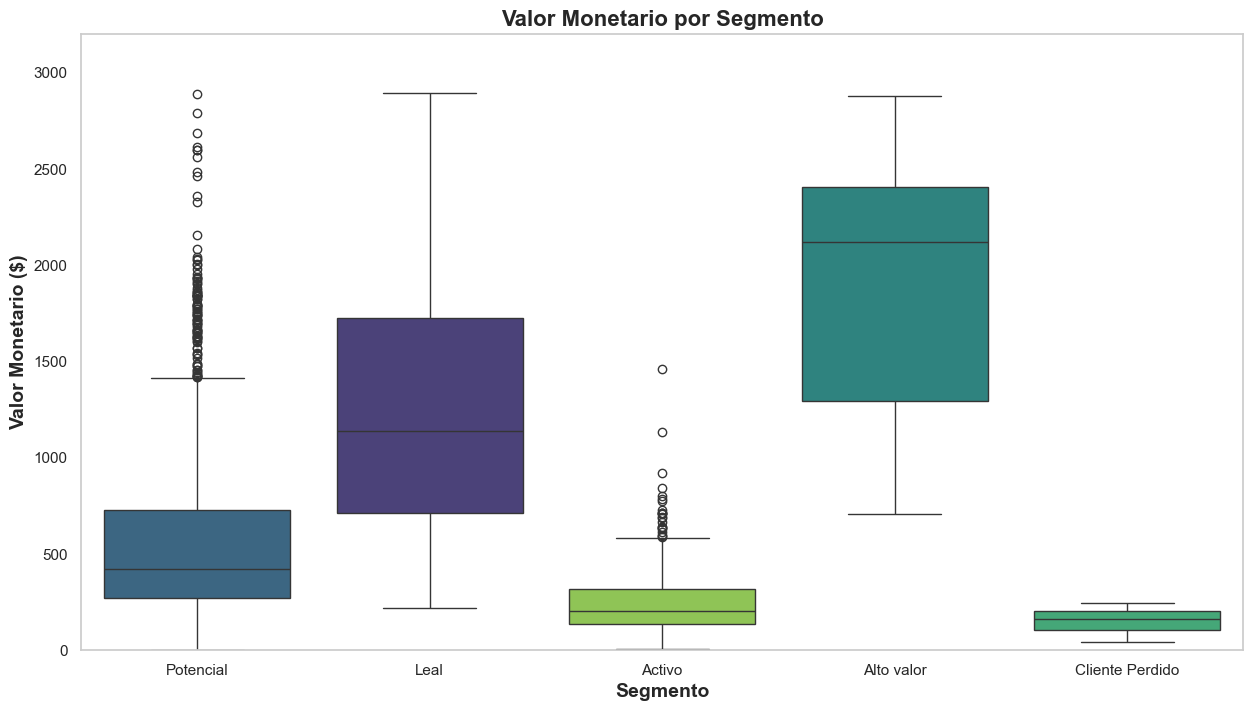

In [1328]:
# Gráfico de Caja y Bigote para Valor Monetario por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Monetary', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment')
plt.title('Valor Monetario por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
#plt.ylim(0, 7000) CON OUTLIERS
plt.ylim(0, 3200)
plt.grid(False)
#plt.savefig('valor_monetario_por_segmento.jpeg', format='jpeg')
plt.show()


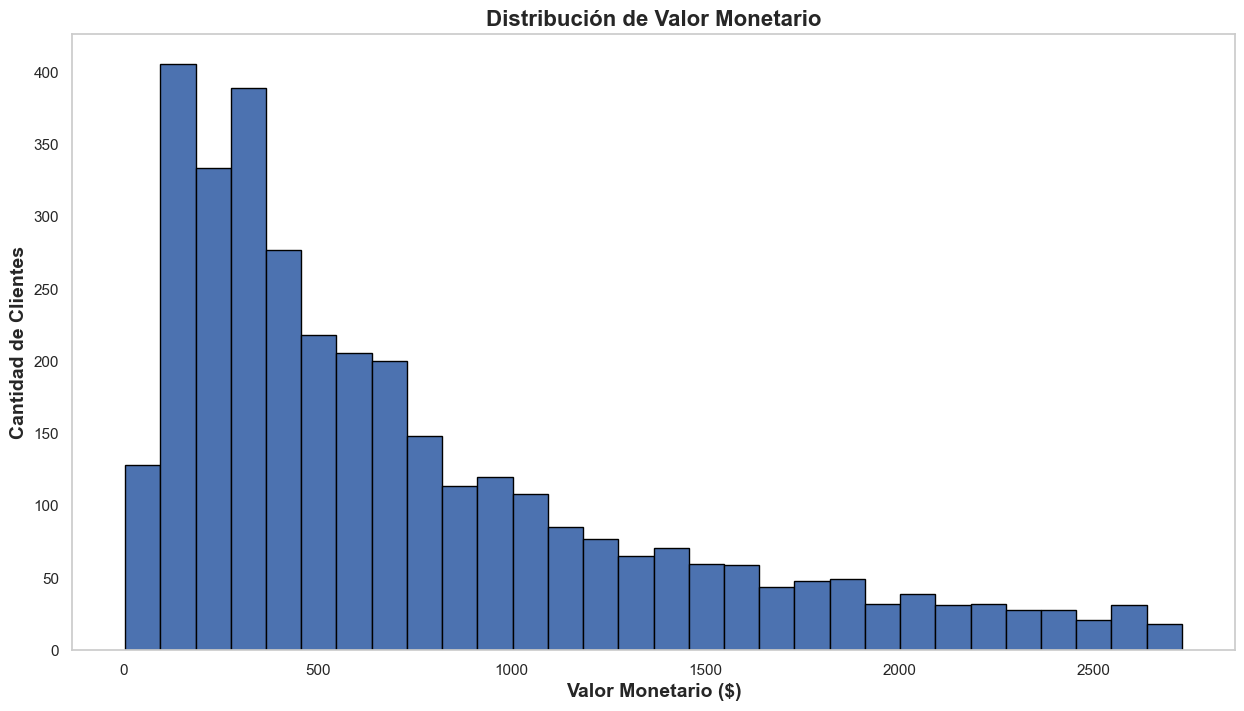

In [1329]:
#histograma
sns.set(style="whitegrid")
filtered_data_m = rfm_df[rfm_df['Monetary'] < rfm_df['Monetary'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_m['Monetary'].hist(bins=30, edgecolor='black', grid= False)
plt.title('Distribución de Valor Monetario', fontsize=16, fontweight='bold')
plt.xlabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')
#plt.savefig('distribucion_valor_monetario.jpeg', format='jpeg')
plt.show()



**Observaciones**

Se observa que la mayoría de los clientes se encuentran en el rango de $0 a $200, mientras que es menos común que los clientes gasten más de $1000.
La alta concentración de clientes en el rango de $0 a $200 sugiere que la empresa tiene una base de clientes amplia y diversa, con muchos clientes que realizan compras de bajo valor.

La presencia de clientes que gastan más de $1000 indica que la empresa tiene segmentos de clientes con mayor poder adquisitivo que realizan compras de alto valor. Sin embargo, el número relativamente bajo de clientes en este segmento sugiere que existe un potencial para aumentar las ventas entre estos clientes.


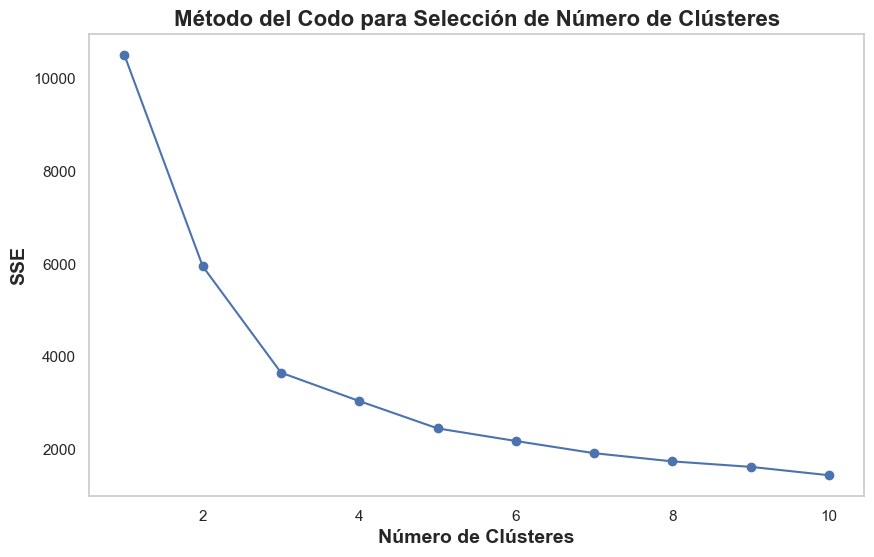

In [1330]:
# Normalizar los datos
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Método del codo para encontrar el número óptimo de clústeres
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo para Selección de Número de Clústeres', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clústeres', fontsize=14, fontweight='bold')
plt.ylabel('SSE', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()



In [1331]:
# Aplicar k-means con el número óptimo de clústeres 
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)


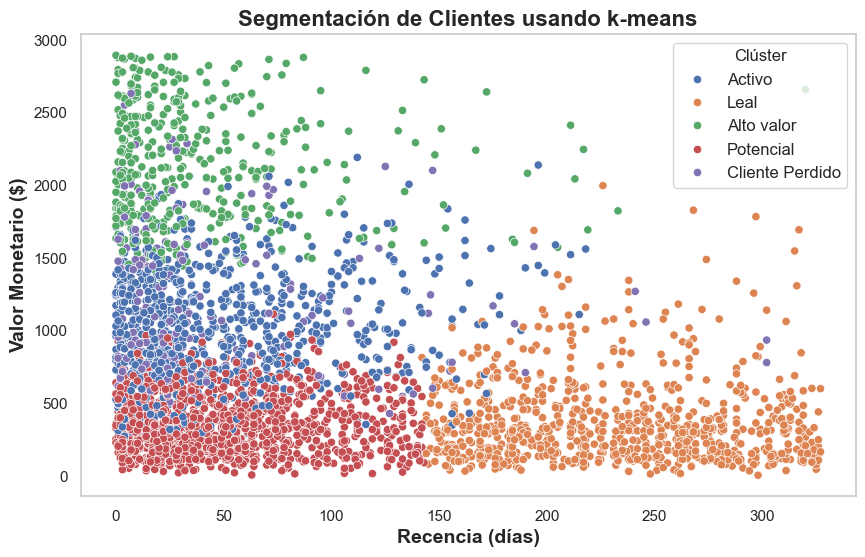

In [1332]:
# Crear un diccionario de mapeo de etiquetas
cluster_names = {
    0: 'Potencial',
    1: 'Cliente Perdido',
    2: 'Leal',
    3: 'Alto valor',
    4: 'Activo'
}

# Asignar las etiquetas a cada cliente
rfm_df['Cluster_name'] = rfm_df['Cluster'].map(cluster_names)

# Visualizar los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster_name')
plt.title('Segmentación de Clientes usando k-means', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.legend(title='Clúster', fontsize=12)
plt.grid(False)
plt.ticklabel_format(style='plain', axis='y')
#plt.savefig('segmentacion de clientes k-means.jpeg', format='jpeg')
plt.show()

**Observaciones**

La gráfica muestra la segmentación de clientes utilizando el algoritmo K-means. El eje X representa el tiempo transcurrido desde la última compra del cliente y el eje Y el total de dinero que el cliente ha gastado en la empresa. 

Los datos se dividen en cinco clústeres, cada uno de los cuales representa un tipo diferente de cliente:

- Clúster "Activo": Este clúster incluye a los clientes que han realizado compras recientemente y que han gastado una cantidad significativa de dinero. Estos son los clientes más valiosos para la empresa.

- Clúster "Leal": Este clúster incluye a los clientes que han realizado compras de manera constante a lo largo del tiempo, pero que no han gastado tanto dinero como los clientes del clúster "Activo". Estos clientes son valiosos para la empresa porque son leales y es probable que continúen comprando en el futuro.

- Clúster "Alto valor": Este clúster incluye a los clientes que han realizado una sola compra de gran valor. Estos clientes son potencialmente valiosos para la empresa, pero es necesario realizar un seguimiento para determinar si continuarán comprando en el futuro.

- Clúster "Potencial": Este clúster incluye a los clientes que han realizado compras recientemente y que han gastado una cantidad moderada de dinero. Estos clientes son potencialmente valiosos para la empresa, pero es necesario realizar un seguimiento para determinar si continuarán comprando en el futuro.

- Clúster "Cliente Perdido": Este clúster incluye a los clientes que no han realizado compras en un período de tiempo prolongado. Estos clientes ya no son valiosos para la empresa y es probable que no regresen.

Se observan las siguientes tendencias 

- El número de clientes en el clúster "Activo" está aumentando con el tiempo. Esto sugiere que la empresa está atrayendo a nuevos clientes valiosos.

- El número de clientes en el clúster "Leal" está disminuyendo con el tiempo. Esto sugiere que la empresa está perdiendo clientes leales.
 
- El número de clientes en el clúster "Alto valor" está fluctuando con el tiempo. Esto sugiere que la empresa no está siendo consistente en la atracción de clientes de alto valor.

- El número de clientes en el clúster "Cliente Perdido" está disminuyendo con el tiempo. Esto sugiere que la empresa está haciendo un mejor trabajo para retener a sus clientes.

In [1333]:
# Distribución de clientes por clúster
rfm_df['Cluster'].value_counts()

Cluster
0    1230
2     828
4     825
3     411
1     208
Name: count, dtype: int64

In [1334]:
print(rfm_df['Cluster_name'].value_counts())

Cluster_name
Potencial          1230
Leal                828
Activo              825
Alto valor          411
Cliente Perdido     208
Name: count, dtype: int64


In [1335]:
# Distribución de clientes por clúster ordenado
print(rfm_df['Cluster_name'].value_counts())

# Estadísticas descriptivas por clúster ordenado
cluster_summary_ordered = rfm_df.groupby('Cluster_name').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
display("Cluster Summary Ordered:", cluster_summary_ordered)

Cluster_name
Potencial          1230
Leal                828
Activo              825
Alto valor          411
Cliente Perdido     208
Name: count, dtype: int64


'Cluster Summary Ordered:'

Recency        Frequency        Monetary              
                   mean median      mean median     mean  median count
Cluster_name                                                          
Activo             48.9   35.0      59.5   58.0   1017.8   994.6   825
Alto valor         39.3   24.0     105.1  104.0   2137.0  2102.1   411
Cliente Perdido    42.8   24.0     163.9  157.5   1123.1   984.3   208
Leal              232.8  234.0      22.3   17.0    368.9   305.5   828
Potencial          52.6   46.0      22.2   20.0    355.4   328.3  1230

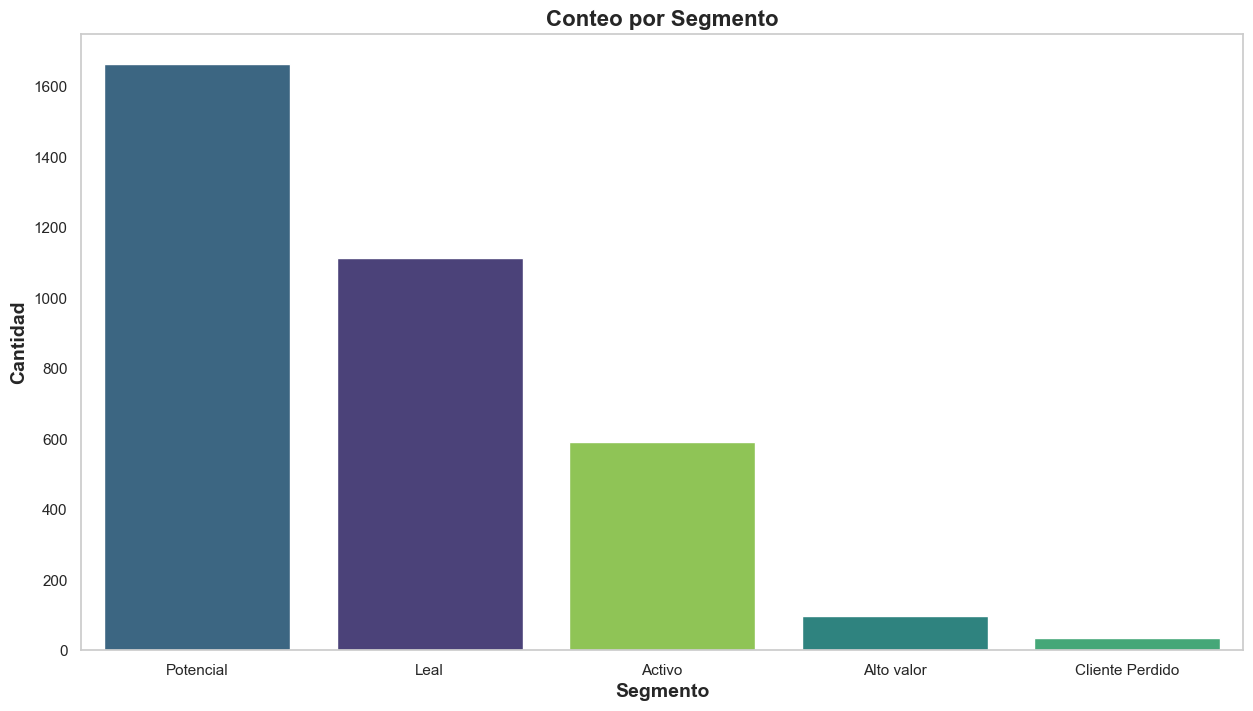

In [1336]:
# Gráfico de Barras de la Distribución de Segmentos

sns.set(style="whitegrid")

plt.figure(figsize=(15,8))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, hue='Segment', palette='viridis', legend=False)


plt.title('Conteo por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad', fontsize=14, fontweight='bold')

plt.grid(False)
#plt.savefig('conteo_por_segmento.jpeg', format='jpeg')
plt.show()

**Observaciones**

Se realizo una segmentacion de cliente con base en la frecuencia con la que compran en la tienda, el monto que suelen gastar en sus compras y el tiempo transcurrido desde su ultima combra. Se obtuvieron 5 segmentos que dividen a los clientes en:
- *Potencial*: Son clientes con actividad superior a la media, en los cuales podemos enformar algun programa especifico para incentivarlos a convertirlos en clientes leales o de alto valor.
- *Leal*: En este grupo encontraremos a los clientes aliosos para la empresa, ya que son propensos a realizar compras repetidas y recomendar nuestros productos o servicios a otros.
- *Activo*: Clientes que utilizan compran nuestros productos de manera regular, sin llegar a superar el promedio de compras o visitas. Este segmento representa la mayor oportunidad de crecimiento para la empresa. Se deben implementar estrategias para aumentar la satisfacción y la lealtad de estos clientes.
- *Alto valor*: Estos clientes generan la mayor parte de los ingresos para la empresa. Es importante enfocarse en este segmento para mantener su satisfacción y lealtad.
- *Cliente Churn*: Estos clientes ya no compran nuestros productos. Es de vital importancia enfocarse en este segmento y analizar las razones por las que estos clientes se han perdido y tomar medidas para evitar que otros clientes se pierdan en el futuro.

In [1337]:
#Creacion de la columna de cancelacion
"""
Función para etiquetar clientes propensos al abandono basado en una categorización previa.

Parámetros:
- row (str): Categoría del cliente ('retenido' o 'perdido').

Devuelve:
- int: 1 si el cliente está categorizado como 'perdido', 0 si está categorizado como 'retenido'.

Ejemplo de uso:
>>> df['Churn'] = df['Categoría'].apply(churn)

Esto aplicará la función `churn` a cada valor de la columna 'Categoría' en el DataFrame `df` para etiquetar clientes propensos al abandono en una nueva columna 'Churn'.
"""

def churn(row):
    if row == 'perdido':
        return 1 # cliente perdido o que probablemente abandone pronto
    else:
        return 0 #menos probabilidad de abandono 



rfm_df['Churn'] = rfm_df['estado_cliente'].apply(churn)

# Modelo de prediccion

In [1338]:
# Invertir Recency para que los valores más altos sean mejor (menor recencia es mejor)
rfm_df['Recency'] = -rfm_df['Recency']

# Características adicionales
df_additional = df.groupby('customer_id').agg({
    'invoice_date': [lambda x: (current_date - x.min()).days,  # Customer Lifetime
                        lambda x: x.diff().mean().days],          # Average Time Between Purchases
    'stock_code': pd.Series.nunique,                                # Number of Distinct Products
   
})

df_additional.columns = ['Customer_Lifetime', 'Avg_Time_Between_Purchases', 'Distinct_Products']
df_additional.reset_index(inplace=True)

# Unir las características adicionales con las métricas RFM
rfm_df = pd.merge(rfm_df, df_additional, on='customer_id')
rfm_df.sample(10)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente,CLTV_Segment,Segment,Cluster,Cluster_name,Churn,Customer_Lifetime,Avg_Time_Between_Purchases,Distinct_Products
1104,14231,-183,925.71,50,5,3,3,11,12.680959,retenido,Leal,Leal,2,Leal,0,289,2.0,47
2654,16851,-3,342.45,20,1,2,2,5,4.691096,retenido,Activo,Activo,0,Potencial,0,51,2.0,17
2584,16737,-52,417.60,1,3,1,2,6,5.720548,perdido,Potencial,Activo,0,Potencial,1,52,NaN,1
1643,15139,-239,178.96,13,5,1,1,7,2.451507,retenido,En riesgo/ Perdido,Potencial,2,Leal,0,337,8.0,13
143,12586,-16,196.94,11,2,1,1,4,2.697808,retenido,En riesgo/ Perdido,Activo,0,Potencial,0,16,0.0,11
402,13046,-30,629.31,35,2,3,3,8,8.620685,retenido,Potencial,Potencial,0,Potencial,0,265,6.0,33
2491,16566,-14,614.66,18,2,2,3,7,8.420000,retenido,Potencial,Potencial,0,Potencial,0,293,16.0,14
2432,16461,-177,151.42,33,4,3,1,8,2.074247,retenido,En riesgo/ Perdido,Potencial,2,Leal,0,177,0.0,31
2427,16454,-63,5.90,1,3,1,1,5,0.080822,perdido,En riesgo/ Perdido,Activo,0,Potencial,1,63,NaN,1
2080,15864,-21,1936.32,20,2,2,4,8,26.524932,retenido,Alto Valor,Potencial,4,Activo,0,316,15.0,16


Churn
0    3444
1      58
Name: count, dtype: int64


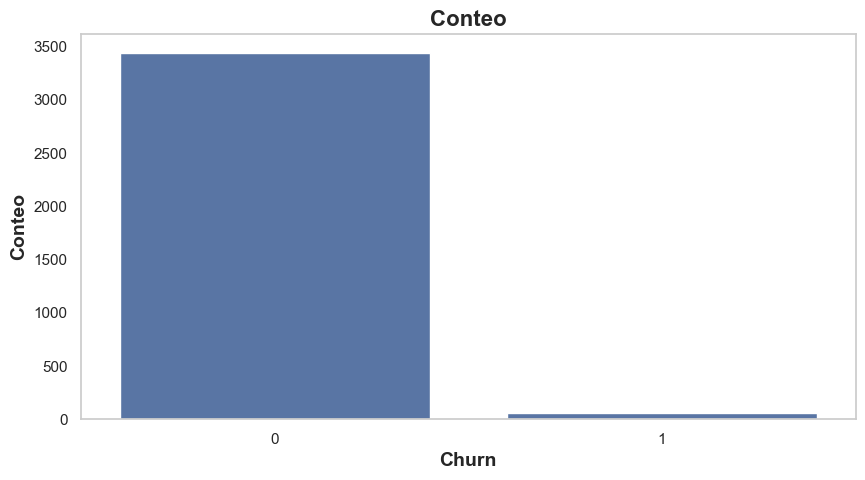

In [1339]:
#Vamos a explorar como se comporta nuestra variable objetivo
class_counts = rfm_df['Churn'].value_counts()

print(class_counts)
plt.figure(figsize=(10,5))
plt.title('Conteo', fontsize=16, fontweight='bold')
plt.xlabel('Churn', fontsize=14, fontweight='bold')
plt.ylabel('Conteo', fontsize=14, fontweight='bold')
sns.countplot(x='Churn', data=rfm_df)
plt.grid(False)
plt.show()

In [1340]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = rfm_df[['Recency', 'Frequency', 'Monetary', 'Distinct_Products']]
y = rfm_df['Churn']

# Ajustar y transformar el conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [1341]:
# Crear un pipeline para el manejo de los modelos

pipelines = {
        
    'lgr': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', LogisticRegression(penalty="elasticnet", l1_ratio=0.5))  
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', KNeighborsClassifier())
    ])
}

In [1342]:
param_grids = {
    
    
    'lgr': {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__class_weight': ['balanced']
    },
    'knn': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto'],
        'classifier__leaf_size': [10, 30, 50],
        'classifier__p': [1, 2]
    }
}

In [1343]:
# Inicializar una lista para almacenar los resultados
results = []

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=stratified_k_fold,
                               scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    y_pred = grid_search.predict(X_test)
    
        # Aplicar umbral a las probabilidades
    umbral = 0.5  # Umbral de 0.5 para clasificación binaria
    y_pred_binario = np.where(y_pred_proba >= umbral, 1, 0)

    # Calcular la precisión con las predicciones binarias
    acc_score = accuracy_score(y_test, y_pred_binario)
    f1 = f1_score(y_test, y_pred_binario)
    precision = precision_score(y_test, y_pred_binario)
    recall = recall_score(y_test, y_pred_binario)
    roc_auc = roc_auc_score(y_test, y_pred_binario)
    
    # Guardar los resultados en la lista
    results.append({
        'Modelo': model_name,
        'AUC-ROC': roc_auc,
        'Exactitud': acc_score,
        'f1': f1,
        'Precision': precision,
        'recall': recall,
        'Mejores Parámetros': grid_search.best_params_,
        'Mejor AUC-ROC': grid_search.best_score_
    })

# Crear el DataFrame de resultados
results_df = pd.DataFrame(results)

# Mostrar la tabla de resultados
print(results_df)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\karin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Fitting 5 folds for each of 36 candidates, totalling 180 fits
  Modelo   AUC-ROC  Exactitud   f1  Precision    recall  \
0    lgr  0.973837   0.948571  0.4       0.25  1.000000   
1    knn  0.666667   0.988571  0.5       1.00  0.333333   

                                  Mejores Parámetros  Mejor AUC-ROC  
0  {'classifier__class_weight': 'balanced', 'clas...       0.994618  
1  {'classifier__algorithm': 'auto', 'classifier_...       0.966889  


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\karin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



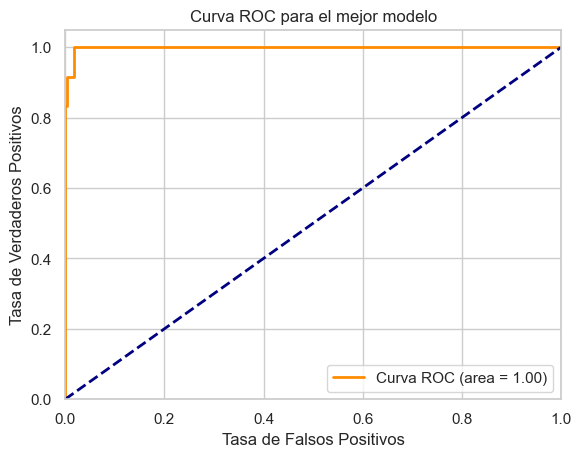

In [1344]:
# Encontrar el mejor modelo basado en el mejor AUC-ROC
best_model_info = max(results, key=lambda x: x['AUC-ROC'])
best_model_name = best_model_info['Modelo']
best_model_pipeline = pipelines[best_model_name]
best_model_params = best_model_info['Mejores Parámetros']

# Ajustar el mejor modelo a todo el conjunto de entrenamiento
best_model = GridSearchCV(best_model_pipeline, param_grids[best_model_name], cv=stratified_k_fold,
                          scoring='roc_auc', n_jobs=-1, verbose=1)
best_model.fit(X_train, y_train)

# Calcular las probabilidades predictivas en el conjunto de prueba
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el mejor modelo')
plt.legend(loc="lower right")
plt.show()

# Insights

1. Distribución de las Ventas por Mes:

    Se identifico que los meses con mayores ventas son septiembre, octubre y noviembre. En diciembre se identifico tambien una baja en las ventas la cual se sugiere coparar con datos de otros años para verificar si es una constante e identificar las posibles causas para generar una estrategia de solucion. 

2. Análisis de la Frecuencia de Compra:

    Se identifico que la mayoria de los clientes regresa a realizar una compra dentro de los 50 dias posteriores. Este numero podria intentar disminuirse con alguna estrategia de marketing determinada como promociones o similares. 

3. Segmentación de Clientes:

    Clasificar a los clientes en diferentes segmentos basados en su comportamiento de compra (por ejemplo, frecuentes, ocasionales, nuevos, etc.). Esto permitirá personalizar las estrategias de marketing para cada segmento.

4. Valor Promedio de las Compras:

    El valor promedio de compra se establece entre los $200 y $1000; sin embargo, se detectaron un par de clientes con compras por encima de los $8,000. Seria importante tomarlos en cuenta para asegurarnos que continuen haciendo compras de alto valor. 

5. Análisis de Productos más Rentables:

    Nuestro dos productos mas vendidos son el papel craft little birdie y medium ceramic top storage jar. Por lo que nuestras estrategias de marketing podrian ir orientadas a este clase de productos para generar mayor rentabilidad. 

6. Tasa de Retención de Clientes:

    Con base en el periodo de tiempo con el que contamos no fue posible determiner la retencion de clientes, pues solo contamos con datos de 2020. Seria prudente comparar estos datos con mas años para obtener informacion mas precisa al respecto. 

7. Comportamiento de Compra por Región:

    La region que sin duda destaca por las ganancias generadas a la empresa es Reino Unido, sugerimos destinar mas estrategias a este mercado. 

8. Integridad de los datos:

    Se detecto una mezcla en los datos de facturas relativa al ingreso de dinero por compras de clientes y facturas relacionadas con pagos de servicios de la empresa, como plataformas de Amazos y envios postales. 


# Conclusiones 

1. Análisis de Ventas por Meses y Años:

    Se observa una concentración de ventas significativa en los meses de septiembre, octubre y noviembre, indicando que son los mejores meses en términos de facturación.
    Diciembre muestra una disminución en las ventas, sugiriendo oportunidades para mejorar las estrategias de ventas durante las festividades.

2. Segmentación de Clientes:

    La segmentación de clientes de la empresa, realizada con el algoritmo K-means, ha revelado cuatro tipos de clientes: Activos, Leales, Alto Valor, Potencial y Perdidos. La información obtenida permite desarrollar estrategias personalizadas para cada segmento, enfocándose en la retención, el aumento del gasto y la conversión de clientes potenciales. Es importante recordar que la segmentación es un proceso continuo y que se deben utilizar herramientas y métodos adicionales para obtener una visión completa de la base de clientes. Invertir en la recopilación de datos, análisis y profesionales especializados permitirá a la empresa aprovechar al máximo la segmentación de clientes para mejorar sus resultados comerciales.

    
3. Distribución del Tiempo de Vida del Cliente:

    La mayoría de los clientes presentan una frecuencia de compra entre 0 y 50 días, sugiriendo tanto clientes nuevos como potencialmente inactivos que podrían reactivarse.

4. Valor Promedio por Compra:

    La mayoría de las transacciones se encuentran por debajo de los $1,000, con un número significativo de clientes en el rango de $200 a $1,000.
    Existe un segmento minoritario pero importante de clientes que realizan compras de alto valor ($1,000+), representando una oportunidad para aumentar las ventas entre estos clientes.
    Se detectaron un par de clientes que realizaron compras de muy alto valor y cantidades de productos especificos, se sugiere analizar la posibilidad de crear estrategias de marketing dirigidas a clientes mayoristas.

5. Evolución del Valor Promedio por Compra:

    Se observa una distribución variada del valor promedio por compra, con la mayoría por debajo de $1,000. Estrategias para aumentar el gasto promedio podrían centrarse en personalizar ofertas según el historial de compras.

6. Segmentación de Clientes por Valor y Frecuencia:

    Se identificaron segmentos como Potencial, Leal, Activo, Alto Valor y Churn, cada uno con necesidades y estrategias específicas para aumentar la satisfacción y lealtad del cliente.

# Recomendaciones


- **Implementar programas de fidelización para clientes**: Los programas de fidelización pueden ayudar a mantener a los clientes comprometidos y reducir la rotación. Estos programas pueden ofrecer beneficios como descuentos, puntos, acceso anticipado a nuevos productos o servicios, y eventos exclusivos.

- **Mejorar el servicio al cliente**: Un buen servicio al cliente puede ayudar a aumentar la satisfacción del cliente y reducir la probabilidad de que se vayan. La empresa debe asegurarse de que sus canales de servicio al cliente sean accesibles y fáciles de usar, y que sus empleados estén capacitados para brindar un servicio de alta calidad.

- **Analizar las razones por las que los clientes se van**: Es importante comprender por qué los clientes se van para poder abordar las causas subyacentes. La empresa puede realizar encuestas de salida o entrevistas a los clientes perdidos para obtener información sobre sus razones para irse.

- **Analizar los factores que impulsan la fidelización**: La empresa debería investigar los factores que impulsan la fidelización de los clientes que realizan más de 100 compras. Esto podría ayudar a identificar estrategias para aumentar la fidelidad entre otros segmentos de clientes.

- **Personalizar las comunicaciones de marketing**: La empresa podría personalizar sus comunicaciones de marketing en función del historial de compras de cada cliente. Esto podría ayudar a aumentar la relevancia de los mensajes de marketing y fomentar la conversión.

- **Analizar los factores que influyen en el gasto**: La empresa debería investigar los factores que influyen en el gasto de los clientes en diferentes rangos de precios. Esto podría incluir factores demográficos, psicográficos, comportamentales y relacionados con los productos y servicios de la empresa.

- **Implementar estrategias para aumentar el gasto promedio**: La empresa podría implementar estrategias para aumentar el gasto promedio de los clientes en el rango de $0 a $200. Esto podría incluir ofrecer descuentos por volumen, promociones especiales, programas de fidelización o mejorar la experiencia de compra en la tienda.

- **Atraer y fidelizar a los clientes de alto valor**: La empresa podría implementar estrategias de marketing personalizadas para atraer y fidelizar a los clientes que gastan más de $1000. Esto podría incluir ofrecer productos y servicios exclusivos, brindar un servicio al cliente excepcional o invitar a eventos especiales.

- **Mejora en Estrategias de Marketing**: Centrarse en los meses con menor rendimiento, como diciembre, con campañas promocionales adecuadas para mejorar las ventas estacionales.

- **Reactivación de Clientes Inactivos**: Utilizar estrategias de reactivación como recordatorios y ofertas especiales para atraer de nuevo a clientes ocasionales y reducir la tasa de abandono.

- **Integridad de los datos**: Implementar un proceso para separar los datos de facturas en dos categorías Facturas de compras de clientes que deben incluir solo los ingresos generados por las compras realizadas por los clientes y Facturas de pagos de servicios donde se incluyan sola los pagos realizados por la empresa por servicios como plataformas de Amazon, envíos postales o cualquier otro servicio similar.


# Anexo

Se realizo un ejercicio con los datos sin procesar, es decir, no se incluyeron las columnas RFM ni CLVT; esto con la finalidad de observar si causaban un sobreajuste en el modelo. El resultado se puede observar en el archivo denominado Modelo RF.ipynb 

In [1345]:

#rfm_df.to_json('rfm_df.json', orient='records')

#print("Archivos JSON generados exitosamente.")